In [1]:
import numpy as np
from matplotlib import pyplot as plt
import decimal
from scipy import signal
%matplotlib inline

# Generating

In [182]:
def square(x):
    x = np.sin(x)
    return np.where(x >= 0, 1, -1).astype(float)

def generate_data(func, noise=0):
    X = np.arange(0, 2*np.pi, 0.01).reshape(-1,1)
    Y = func(2*X)

    clean_X = X[5::10].copy()
    clean_Y = Y[5::10].copy()

    if noise > 0:
        Y += np.random.normal(0, noise, Y.shape)

    train_X = X[::10].copy()
    train_Y = Y[::10].copy()

    test_X = X[5::10].copy()
    test_Y = Y[5::10].copy()

    return train_X, train_Y, test_X, test_Y, clean_X, clean_Y


[[0. ]
 [0.1]
 [0.2]
 [0.3]]
[[0.05]
 [0.15]
 [0.25]
 [0.35]]


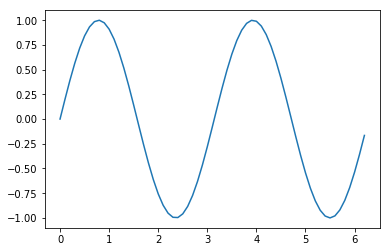

In [3]:
np.random.seed(12)
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(np.sin)
print(train_X[:4])
print(test_X[:4])
plt.plot(train_X,train_Y)

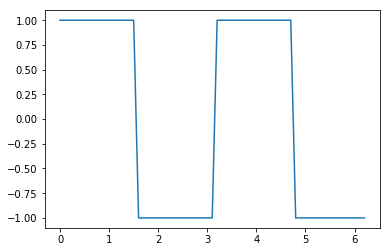

In [4]:
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(square)
plt.plot(train_X,train_Y)

# RBFs

In [58]:
def evenly_spaced_rbf(count):
    centers = []
    for i in range(count):
        centers.append(i*2*np.pi/(count))
    centers = np.reshape(np.array(centers), (len(centers),1))
    return centers

#only works with even numbers why not
def unevenly_spaced_rbf(count):
    centers= []
    A = list(range(count))
    B = A[:len(A)//2]
    C = A[len(A)//2:]
    
    for i in B:
        centers.append(i*2*np.pi/(count*2))
    
    for i in C:
        centers.append(i*2*np.pi/(count))
        
    return centers

def random_rbf(count):
    centers = []
    for i in range(count):
        centers.append(2*np.random.random_sample()*np.pi)
    
    centers = np.reshape(np.array(centers), (len(centers),1))
    return centers

def custom_rbf():
    return np.array([[   ]]) #put stuff here

In [60]:
random_rbf(3)

array([[4.2388359 ],
       [3.05865797],
       [0.39053068]])

# Network

In [464]:
class RBF():
    def __init__(self, centers, sigma=0.1, use_batch=True, threshold = False):
        self.sigma = sigma
        self.centers = centers
        self.use_batch = use_batch
        self.weights = None
        self.threshold = threshold
        
    def RBF(self, x, mu, sigma):
        return np.exp((-(np.linalg.norm(x-mu))**2)/(2*sigma**2))
    
    def gaussian(self,x,mu,sigma):
        argument=(-(x-mu)**2)/2*sigma**2
        return np.exp(argument)
    
    def get_phi(self, X):
        N = len(X)
        n = len(self.centers)
        phi = np.zeros((N,n))
        
        for i in range(n):
            phi[:,i]=self.gaussian(X[:,0],self.centers[i,:],self.sigma)

        return phi
    
    def get_phi_old(self, X):
        N = len(X)
        n = len(self.centers)
        phi = np.zeros((N,n))

        for i in range(N):
            for j in range(n):
                phi[i,j] = self.RBF(X[i,:], self.centers[j,:], self.sigma)
                
        return phi
    
    def predict(self,X):
        phi = self.get_phi(X)
        return phi.dot(self.weights)
    
    def shuffle(self, X, Y):
        n = X.shape[0]
        n_X = np.zeros((n,1))
        n_Y = np.zeros((n,1))
        
        idx = np.random.permutation(n)
        for i in idx:
            n_X[i][0] = X[idx[i]][0]
            n_Y[i][0] = Y[idx[i]][0]
        
        return n_X, n_Y
    
    def calculate_error_ABS(self, X, Y):
        predictions = self.predict(X)
        if self.threshold:
            predictions = np.where(predictions >= 0, 1, -1).astype(float)
            
        return np.mean(np.abs(Y-predictions))
    
    def calculate_error_MSE(self, X, Y):
        predictions = self.predict(X)
        if self.threshold:
            print("here in threshold")
            predictions = np.where(predictions >= 0, 1, -1).astype(float)       
        return np.mean(np.square(Y-predictions))/2
    
    

    def do_sequential(self,patterns,targets,sigma,epochs,eta):
        
        #             self.weights = np.random.randn(len(self.centers),1)
#             train_Xn, train_Yn = self.shuffle(train_X,train_Y)
#             phi = self.get_phi(train_Xn)
#             phi_T = phi.T
            
#             for i in range(n_epochs):
#                 for j in range(train_Xn.shape[0]):
#                     inner = train_Yn[j][0] - np.dot(phi[j,:], self.weights)
#                     delta = eta*inner*phi[j,:].T
#                     self.weights = np.add(self.weights, np.reshape(delta,np.shape(self.weights)))

        learning_error_list=[]
        W=np.random.randn(len(self.centers),1)
        mu = self.centers
        
        for i in range(epochs):
            tmp=[]
            for k in range(np.shape(targets)[0]):
                phi = self.get_phi(patterns)
                e=targets[k]-phi[k,:].dot(W)
                error=np.float(0.5*(e**2))
                tmp.append(error)
                W=W+eta*e*phi[k,:].reshape(len(self.centers),1)
                
            learning_error=np.mean(tmp)
            learning_error_list.append(learning_error)

        return W, learning_error_list


    
    def train(self, train_X, train_Y, test_X, test_Y, n_epochs, eta = 0.3, plot = True, v=True):
        learning_erros = None
        if(self.use_batch):
            phi = self.get_phi(train_X)
            phi_T = phi.T
#             self.weights = np.linalg.inv(np.dot(phi_T,phi)).dot(phi_T).dot(train_Y)
            self.weights = np.linalg.solve((phi_T).dot(phi),(phi_T).dot(train_Y))
        else:
            self.weights, learning_errors = self.do_sequential(train_X, train_Y,sigma,n_epochs,eta)
            train_err = self.calculate_error_ABS(train_X,train_Y)
            test_err = self.calculate_error_ABS(test_X,test_Y)
#             self.weights = np.random.randn(len(self.centers),1)
#             train_Xn, train_Yn = self.shuffle(train_X,train_Y)
#             phi = self.get_phi(train_Xn)
#             phi_T = phi.T
            
#             for i in range(n_epochs):
#                 for j in range(train_Xn.shape[0]):
#                     inner = train_Yn[j][0] - np.dot(phi[j,:], self.weights)
#                     delta = eta*inner*phi[j,:].T
#                     self.weights = np.add(self.weights, np.reshape(delta,np.shape(self.weights)))
        
        train_err = self.calculate_error_ABS(train_X,train_Y)
        test_err = self.calculate_error_ABS(test_X,test_Y)
        if(plot):
            plt.plot(train_X, self.predict(train_X))
            plt.title("Training")
            plt.show()
            
            print("MSE Error: " + str(self.calculate_error_MSE(train_X,train_Y)))
            print("ABS Error: " + str(train_err))

            plt.plot(test_X, network.predict(test_Y))
            plt.title("Testing")
            plt.show()
            
            print("MSE Error: " + str(self.calculate_error_MSE(test_X,test_Y)))
            print("ABS Error: " + str(test_err))
        elif v:
            print("MSE Error: " + str(self.calculate_error_MSE(train_X,train_Y)))
            print("ABS Error: " + str(train_err))

            print("MSE Error: " + str(self.calculate_error_MSE(test_X,test_Y)))
            print("ABS Error: " + str(test_err))
        if not self.use_batch:
            return train_err, test_err, learning_errors 
        return train_err, test_err
            

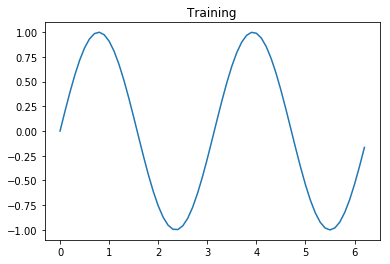

MSE Error: 1.1885862212804407e-09
ABS Error: 4.417508147375061e-05


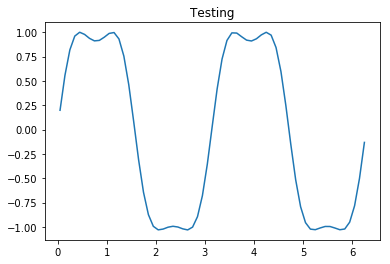

MSE Error: 1.2860511215246419e-09
ABS Error: 4.461674773990799e-05


(4.417508147375061e-05, 1.2860511215246419e-09)

In [361]:
np.random.seed(10)
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(lambda x:np.sin(x))
# print(train_X[:,0])
# print(train_Y.shape)
centers = evenly_spaced_rbf(19)
network = RBF(centers, sigma=1, use_batch=True)
network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=1000)

8 0.08445870821389793
11


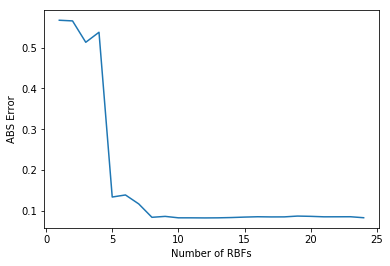

In [429]:
#testing n rbfs 
train_errs = []
test_errs = []
idx = []
large = False
medium = False
small = False

for i in range(1,25):
    centers = evenly_spaced_rbf(i)
    network = RBF(centers, sigma=1, use_batch=True)
    train,test = network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=1000, plot=False, v=False)
    train_errs.append(train)
    test_errs.append(test)
    idx.append(i)
    
    if(test < 0.1 and not large):
        large = True
        print(str(i) + " " + str(test))
    if(test < 0.01 and not medium):
        medium = True
        print(str(i) + " " + str(test))
    if(test < 0.001 and not small):
        small = True
        print(str(i) + " " + str(test))

# plt.plot(idx, train_errs)
plt.plot(idx,test_errs)
plt.xlabel("Number of RBFs")
plt.ylabel("ABS Error")

print(np.argmin(test_errs))

# plt.axhline(y=0.1, color='r', linestyle='-')
# plt.axhline(y=0.01, color='r', linestyle='-')
# plt.axhline(y=0.001, color='r', linestyle='-')

(63, 1)
(63, 1)


Text(0, 0.5, 'ABS Error')

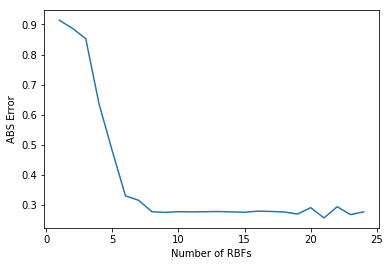

In [222]:
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(square)
print(train_X.shape)
print(train_Y.shape)

train_errs = []
test_errs = []
idx = []
large = False
medium = False
small = False

for i in range(1,25):
    centers = evenly_spaced_rbf(i)
    network = RBF(centers, sigma=0.6, use_batch=True)
    train,test = network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=1000, plot=False, v=False)
    train_errs.append(train)
    test_errs.append(test)
    idx.append(i)
    
    if(test < 0.1 and not large):
        large = True
        print(str(i) + " " + str(test))
    if(test < 0.01 and not medium):
        medium = True
        print(str(i) + " " + str(test))
    if(test < 0.001 and not small):
        small = True
        print(str(i) + " " + str(test))

# plt.plot(idx, train_errs)
plt.plot(idx,test_errs)
plt.xlabel("Number of RBFs")
plt.ylabel("ABS Error")

# plt.axhline(y=0.1, color='r', linestyle='-')
# plt.axhline(y=0.01, color='r', linestyle='-')
# plt.axhline(y=0.001, color='r', linestyle='-')

6 0.06349206349206349
8 0.0
8 0.0


Text(0, 0.5, 'ABS Error')

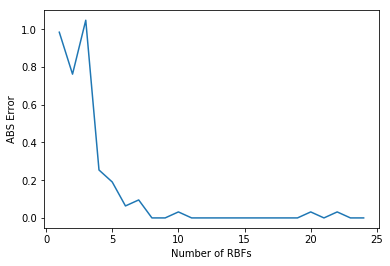

In [180]:
train_errs = []
test_errs = []
idx = []
large = False
medium = False
small = False

for i in range(1,25):
    centers = evenly_spaced_rbf(i)
    network = RBF(centers, sigma=0.6, use_batch=True, threshold = True)
    train,test = network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=1000, plot=False, v=False)
    train_errs.append(train)
    test_errs.append(test)
    idx.append(i)
    
    if(test < 0.1 and not large):
        large = True
        print(str(i) + " " + str(test))
    if(test < 0.01 and not medium):
        medium = True
        print(str(i) + " " + str(test))
    if(test < 0.001 and not small):
        small = True
        print(str(i) + " " + str(test))

# plt.plot(idx, train_errs)
plt.plot(idx,test_errs)
plt.xlabel("Number of RBFs")
plt.ylabel("ABS Error")

# plt.axhline(y=0.1, color='r', linestyle='-')
# plt.axhline(y=0.01, color='r', linestyle='-')
# plt.axhline(y=0.001, color='r', linestyle='-')

6
[0.9995426388748944, 0.8718088728946988, 1.0076066657917784, 0.46924128201163867, 0.4083602320724441, 0.36361789356607926, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672, 0.3612326860097672]


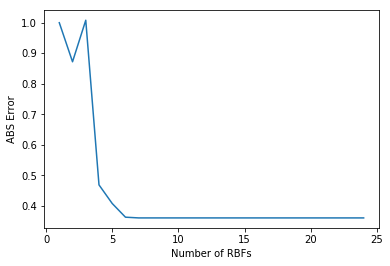

In [433]:
#noisy data
np.random.seed(10)
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(np.sin, noise = 0.1)

train_errs = []
test_errs = []
idx = []
large = False
medium = False
small = False

for i in range(1,25):
    centers = evenly_spaced_rbf(i)
    network = RBF(centers, sigma=0.6, use_batch=True, threshold = True)
    train,test = network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=1000, plot=False, v=False)
    train_errs.append(train)
    test_errs.append(test)
    idx.append(i)
    
    if(test < 0.1 and not large):
        large = True
        print(str(i) + " " + str(test))
    if(test < 0.01 and not medium):
        medium = True
        print(str(i) + " " + str(test))
    if(test < 0.001 and not small):
        small = True
        print(str(i) + " " + str(test))

# plt.plot(idx, train_errs)
plt.plot(idx,test_errs)
plt.xlabel("Number of RBFs")
plt.ylabel("ABS Error")
print(np.argmin(test_errs))
print(test_errs)


0.44495645874891315
5


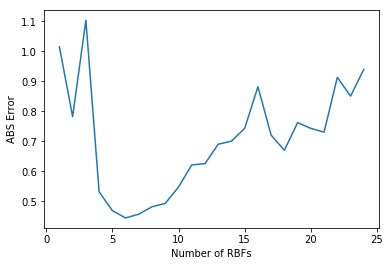

In [365]:
#Online, noisy data
np.random.seed(10)
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(np.sin, noise = 0.1)

train_errs = []
test_errs = []
idx = []
large = False
medium = False
small = False

for i in range(1,25):
    centers = evenly_spaced_rbf(i)
    network = RBF(centers, sigma=0.6, use_batch=False, threshold = True)
    train,test,_ = network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=100, plot=False, v=False)
    train_errs.append(train)
    test_errs.append(test)
    idx.append(i)
    
    if(test < 0.1 and not large):
        large = True
        print(str(i) + " " + str(test))
    if(test < 0.01 and not medium):
        medium = True
        print(str(i) + " " + str(test))
    if(test < 0.001 and not small):
        small = True
        print(str(i) + " " + str(test))

# plt.plot(idx, train_errs)
plt.plot(idx,test_errs)
plt.xlabel("Number of RBFs")
plt.ylabel("ABS Error")
print(str(min(test_errs)))
print(np.argmin(test_errs))

In [456]:
#Batch, testing width, fix square at 7 and sin at 6
np.random.seed(10)
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(square, noise = 0.1)

train_errs = []
test_errs = []
idx = []
large = False
medium = False
small = False
centers = evenly_spaced_rbf(6)
sigmas = [0.0001, 0.1, 0.6, 1, 5]    
for i in sigmas:
    network = RBF(centers, sigma=i, use_batch=True, threshold = True)
    train,test = network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=1000, plot=False, v=True)
    train_errs.append(train)
    test_errs.append(test)
    idx.append(i)

print(test_errs)

# train_errs = []
# test_errs = []
# idx = []
# large = False
# medium = False
# small = False
# centers = evenly_spaced_rbf(6)
# sigmas = [0.0001, 0.1, 0.6, 1, 5]   
# for i in sigmas:
#     network = RBF(centers, sigma=i, use_batch=False, threshold = True)
#     train,test,learn = network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=100, plot=False, v=False)
#     train_errs.append(train)
#     test_errs.append(test)
#     idx.append(i)
#     print(len(learn))
#     plt.plot(np.arange(0,100,1),learn, label = str(i))

# print(test_errs)
# plt.legend()
# plt.ylim(0,0.8)
# plt.show()
# np.random.seed(10)
# train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(square, noise = 0.1)

# train_errs = []
# test_errs = []
# idx = []
# large = False
# medium = False
# small = False
# centers = evenly_spaced_rbf(6)
# sigmas = np.arange(0.1, 4, 0.1)    
# for i in sigmas:
#     network = RBF(centers, sigma=i, use_batch=True, threshold = True)
#     train,test = network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=1000, plot=False, v=False)
#     train_errs.append(train)
#     test_errs.append(test)
#     idx.append(i)

# # plt.plot(idx, train_errs)
# plt.plot(idx,test_errs, label="Square Data")
# plt.xlabel("Sigma")
# plt.ylabel("ABS Error")
# print(str(min(test_errs)))
# print(sigmas[np.argmin(test_errs)])

here in threshold
MSE Error: 1.0167062132850384
ABS Error: 1.0487904980575926
here in threshold
MSE Error: 1.0044770727303323
ABS Error: 1.0290253413704344
here in threshold
MSE Error: 0.258548222257534
ABS Error: 0.32630548583390534
here in threshold
MSE Error: 0.3083713612312246
ABS Error: 0.35238000890930843
here in threshold
MSE Error: 0.06209633601564298
ABS Error: 0.136796787002194
here in threshold
MSE Error: 0.0746192185406716
ABS Error: 0.1324101329555834
here in threshold
MSE Error: 0.005490608703203145
ABS Error: 0.08181237528149342
here in threshold
MSE Error: 0.0746192185406716
ABS Error: 0.1324101329555834
here in threshold
MSE Error: 0.12832277327752412
ABS Error: 0.19789107284996488
here in threshold
MSE Error: 0.09630124973974918
ABS Error: 0.16093367851475546
[1.0290253413704344, 0.35238000890930843, 0.1324101329555834, 0.1324101329555834, 0.16093367851475546]


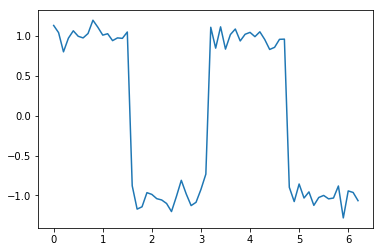

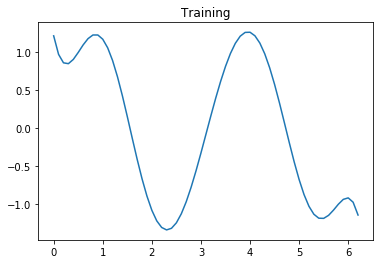

here in threshold
MSE Error: 0.005490608703203145
ABS Error: 0.08181237528149342


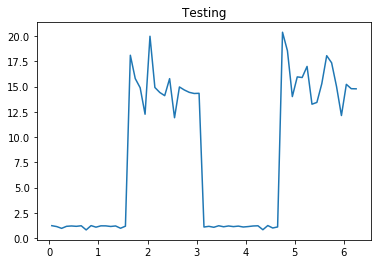

here in threshold
MSE Error: 0.004285640688513617
ABS Error: 0.0689180694635199
0.0689180694635199
here in threshold


0.0

In [465]:
np.random.seed(10)
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(square, noise = 0.1)
plt.plot(train_X,train_Y)
plt.show()
centers = evenly_spaced_rbf(11)
network = RBF(centers, sigma=0.6, use_batch=True, threshold=True)
stuff = network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=100, plot=True, v=True)
print(stuff[1])
network.calculate_error_MSE(clean_X,clean_Y)

# Competitive Learning

In [345]:
def competitive_rbf(X,count,eta,iters, k_min = 1, plot=True):
    np.random.shuffle(X)
    centers = X[0:count].copy() #initialize RBF to data
    
    if(plot):
        plt.scatter(centers[:,0],centers[:,1], label="Before")
    
    for i in range(iters):
        train_vec = X[np.random.randint(0,len(X)),:] # get random vector
        distances = np.empty((0,0))
        for c in centers:
            distances = np.append(distances,(np.linalg.norm(c-train_vec)))
        

        idx = np.argpartition(distances, k_min)
        e = eta
        for j in idx[:k_min]:
            centers[j] += e * (train_vec-centers[j])
            e = e*0.8
            
            
    if(plot):
        plt.scatter(centers[:,0],centers[:,1], label="After")
        plt.title("Competitive RBF Centers Before and After Training")
        plt.legend()
        plt.show()
    
    return centers

(63, 1)
(63, 1)


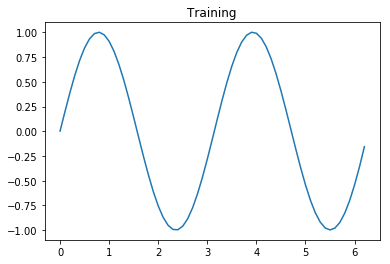

MSE Error: 2.8695813075347942e-06
ABS Error: 0.001826718635230568


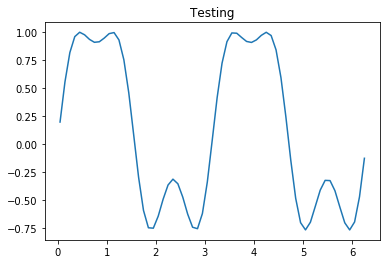

MSE Error: 4.4632448782514e-06
ABS Error: 0.001986931859928294
uniform


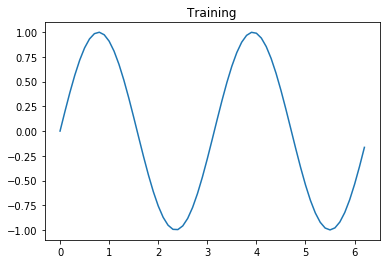

MSE Error: 6.791354707111593e-08
ABS Error: 0.0002892158108667659


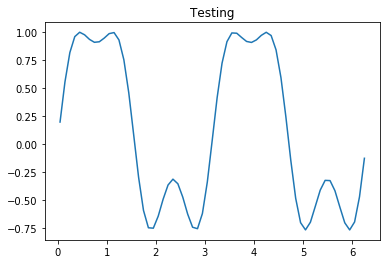

MSE Error: 1.1076415011133604e-07
ABS Error: 0.00031198362400814024


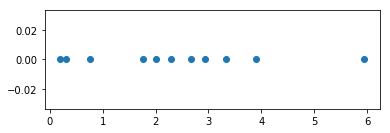

In [449]:
np.random.seed(10)
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(np.sin)
print(train_X.shape)
print(train_Y.shape)
centers = competitive_rbf(train_X.copy(),11,0.8,10,k_min=1,plot=False)
centers2 = evenly_spaced_rbf(11)

network = RBF(centers, sigma=0.6)
network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=100)

print("uniform")
network2 = RBF(centers2, sigma=0.6)
network2.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=100)

plt.subplot(2, 1, 1)
plt.scatter(centers,np.zeros(11))

(63, 1)
(63, 1)


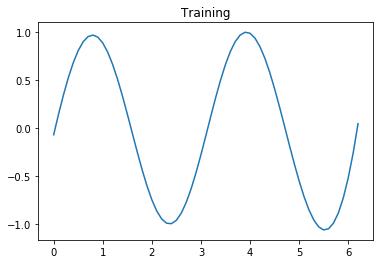

MSE Error: 0.0021290183397072618
ABS Error: 0.051373365333827255


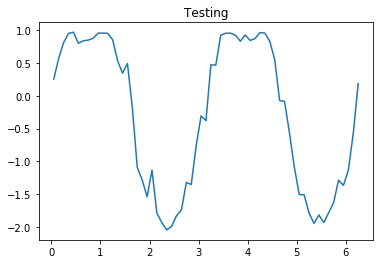

MSE Error: 0.005784296991077488
ABS Error: 0.08480843293694187


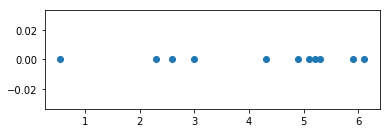

uniform


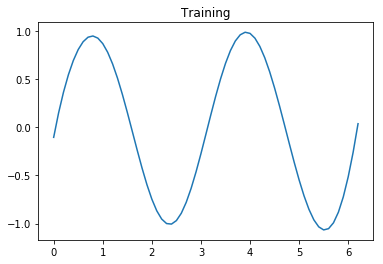

MSE Error: 0.0020709090697659176
ABS Error: 0.0510752229427326


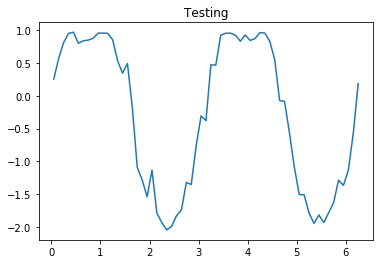

MSE Error: 0.005779397399978376
ABS Error: 0.08442178213021208


(0.0510752229427326, 0.08442178213021208)

In [451]:
np.random.seed(13)
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(np.sin, noise=0.1)
print(train_X.shape)
print(train_Y.shape)
centers = competitive_rbf(train_X.copy(),11,0.8,10,k_min=1,plot=False)
centers2 = evenly_spaced_rbf(11)

network = RBF(centers, sigma=0.6)
network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=100)
plt.subplot(2, 1, 1)
plt.scatter(centers,np.zeros(11))
plt.show()

print("uniform")
network2 = RBF(centers2, sigma=0.6)
network2.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=100)



(63, 1)
(63, 1)


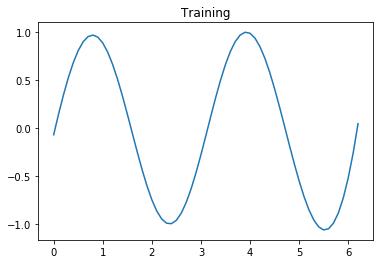

MSE Error: 0.0021290183397072618
ABS Error: 0.051373365333827255


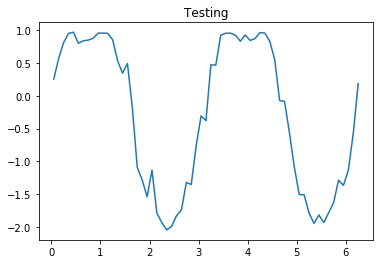

MSE Error: 0.005784296991077488
ABS Error: 0.08480843293694187


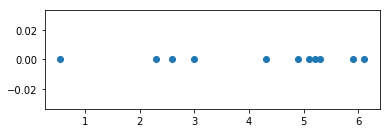

uniform


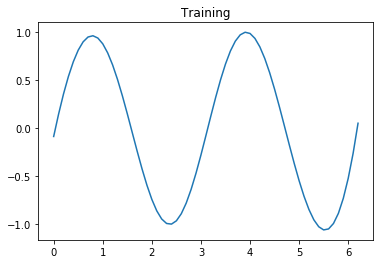

MSE Error: 0.0021085882688450007
ABS Error: 0.051334605223724274


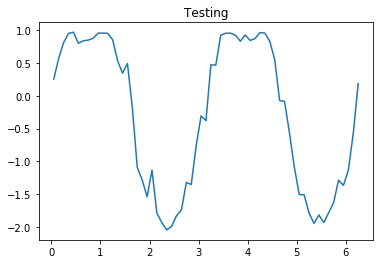

MSE Error: 0.005777093513359018
ABS Error: 0.08472699834688892


(0.051334605223724274, 0.08472699834688892)

In [453]:
np.random.seed(13)
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(np.sin, noise=0.1)
print(train_X.shape)
print(train_Y.shape)
centers = competitive_rbf(train_X.copy(),11,0.8,10,k_min=1,plot=False)
centers2 = competitive_rbf(train_X.copy(),11,0.8,10,k_min=3,plot=False)

network = RBF(centers, sigma=0.6)
network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=100)
plt.subplot(2, 1, 1)
plt.scatter(centers,np.zeros(11))
plt.show()

print("uniform")
network2 = RBF(centers2, sigma=0.6)
network2.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=100)

# Ballistic Data

current directory is : /home/xun/Documents/ANN-Assignment1-GS/A2
(100, 2)


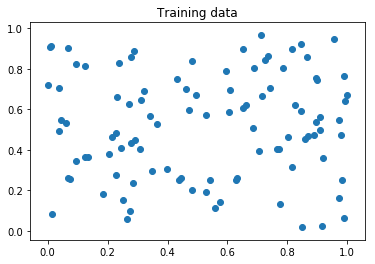

In [32]:
import os
import io

dirpath = os.getcwd()
print("current directory is : " + dirpath)

s = open("ballist.dat").read().replace('\t',' ')
ballistic_data = np.loadtxt(io.StringIO(s),skiprows=0, delimiter=" ")

s2 = open("balltest.dat").read().replace('\t',' ')
balltest_data = np.loadtxt(io.StringIO(s2), delimiter=" ", skiprows=0)

trainb_X = ballistic_data[:,0:2]
trainb_Y = ballistic_data[:,2:4]
testb_X = balltest_data[:,0:2]
testb_Y = balltest_data[:,2:4]

print(trainb_X.shape)
plt.scatter(trainb_X[:,0], trainb_X[:,1])
plt.title('Training data')
plt.show()

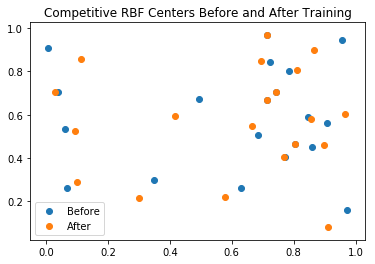

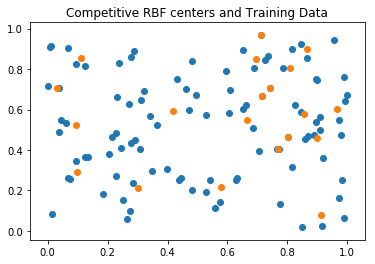

ValueError: operands could not be broadcast together with shapes (100,) (2,) 

In [454]:
sigma = 0.3
eta = 0.2
nodecount = 20
iterations = 100

centers = competitive_rbf(train_ballistic, nodecount, eta, iterations, plot=True)

plt.scatter(trainb_X[:,0], trainb_X[:,1], label="Training")
plt.scatter(centers[:,0], centers[:,1], label="RBF Centers")
plt.title('Competitive RBF centers and Training Data')
plt.show()
network = RBF(centers, sigma=sigma)
network.train(trainb_X,trainb_Y,testb_X,testb_Y,eta=0.2, n_epochs=100, plot=False)